In [519]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
import random 

%matplotlib inline

In [520]:
class Value:
    def __init__(self, data, _children=(), _op='', label =''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Empty function
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # converts other number to type Value
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') # pass children back to the new value
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        # converts other number to type Value
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') # pass children back to the new value
        
        def _backward():
            self.grad += out.grad * other.data 
            other.grad += out.grad * self.data 
            # why do we need a self.grad and other.grad?
            # because we need to pass the gradient back to the previous value
            # and we need to pass the gradient back to the other value.
            # what is the other value? the other value is the one that we're multing by
        out._backward = _backward
        
        return out    
    
      
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad # this is the chain rule expression for the power rule
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other # this is reverse multiplication, we can do i.e. 3*x
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __neg__(self): 
        return self * -1
    
    def __sub__(self, other):
        return self + (-other) # this is reverse subtraction, we can do i.e. 3-x

    def __rsub__(self, other):
        return other + (-self)


    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+ 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += out.grad * (1.0 - t**2) 
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
            
        def _backward():
            self.grad += out.grad * out.data # out.data is e^x
        out._backward = _backward

        return out
            
    
    def backward(self):
        # topological sort
        # this is a way to order the nodes in the graph so that we can compute ...
        # ... the gradients in the right order
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [521]:
a = Value(2.0)
a + 1
a * 2

2 * a # this will automatically call the __rmul__ method and then the __mul__ method

b = Value(4.0)

a / b


Value(data=0.5)

In [522]:
from graphviz import Digraph
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz-12.2.1-win64/bin/'

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    # Create a left-to-right graph in SVG format
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # For any value node, draw a rectangular record with its data
        dot.node(name=uid,
                 label= "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad),
                 shape='record')
        # If this value came from an operation, add an op-node and link
        if n._op:
            op_uid = uid + n._op
            dot.node(name=op_uid, label=n._op)
            dot.edge(op_uid, uid)

    for n1, n2 in edges:
        # Connect the output of n1 into the op-node of n2
        from_uid = str(id(n1))
        to_uid   = str(id(n2)) + n2._op
        dot.edge(from_uid, to_uid)

    return dot


<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
C:\Users\evanl\AppData\Local\Temp\ipykernel_28612\1023512222.py:3: SyntaxWarning: invalid escape sequence '\P'
  os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz-12.2.1-win64/bin/'


In [523]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1,w1
w1 = Value(-3.0, label ="w1")
w2 = Value(1.0, label="w2")

b = Value(6.88137, label="b")
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label ='n'

o = n.tanh(); o.label = 'o'

In [524]:
o.backward()

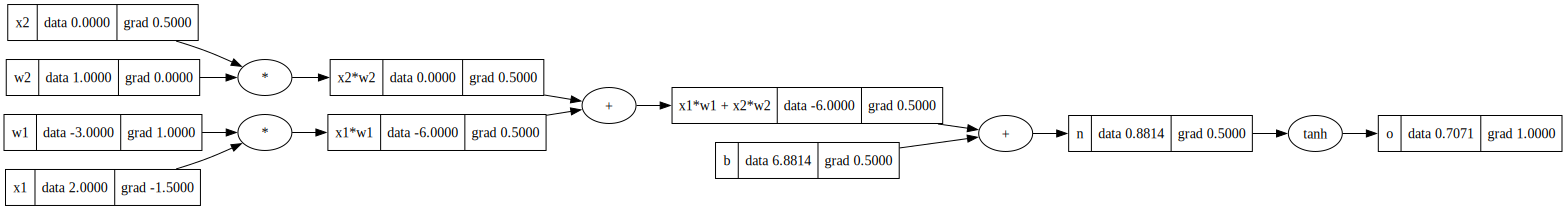

In [525]:
draw_dot(o)

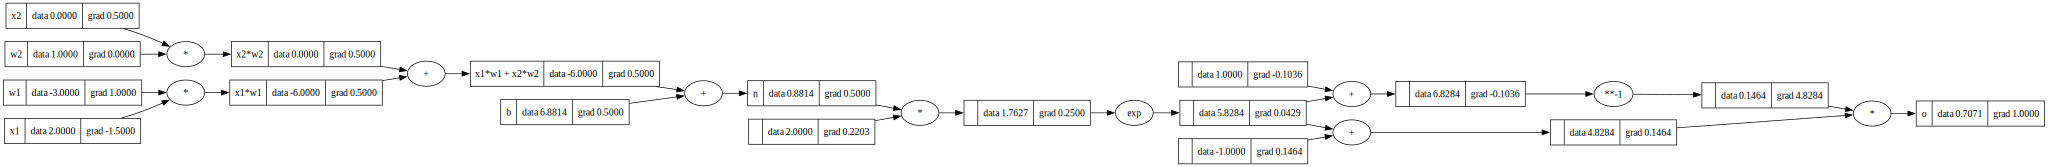

In [526]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1,w1
w1 = Value(-3.0, label ="w1")
w2 = Value(1.0, label="w2")

b = Value(6.88137, label="b")
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label ='n'
# ----------
e = (2*n).exp()
o = (e - 1) / (e + 1)

#----------
o.label = 'o'
o.backward()
draw_dot(o)

In [527]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons] #  for every neuron n in the layer, apply it to the input x
        return outs[0] if len(outs) == 1 else outs # ^^ basically applies neuron to each input x?? 

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # ^^ just a list comprehension 

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [528]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 3 inputs in first layer, 4 inputs in second, 4 inputs in third, 1 output in last
n(x)

Value(data=-0.8541312015179321)

In [529]:
len(n.parameters())

41

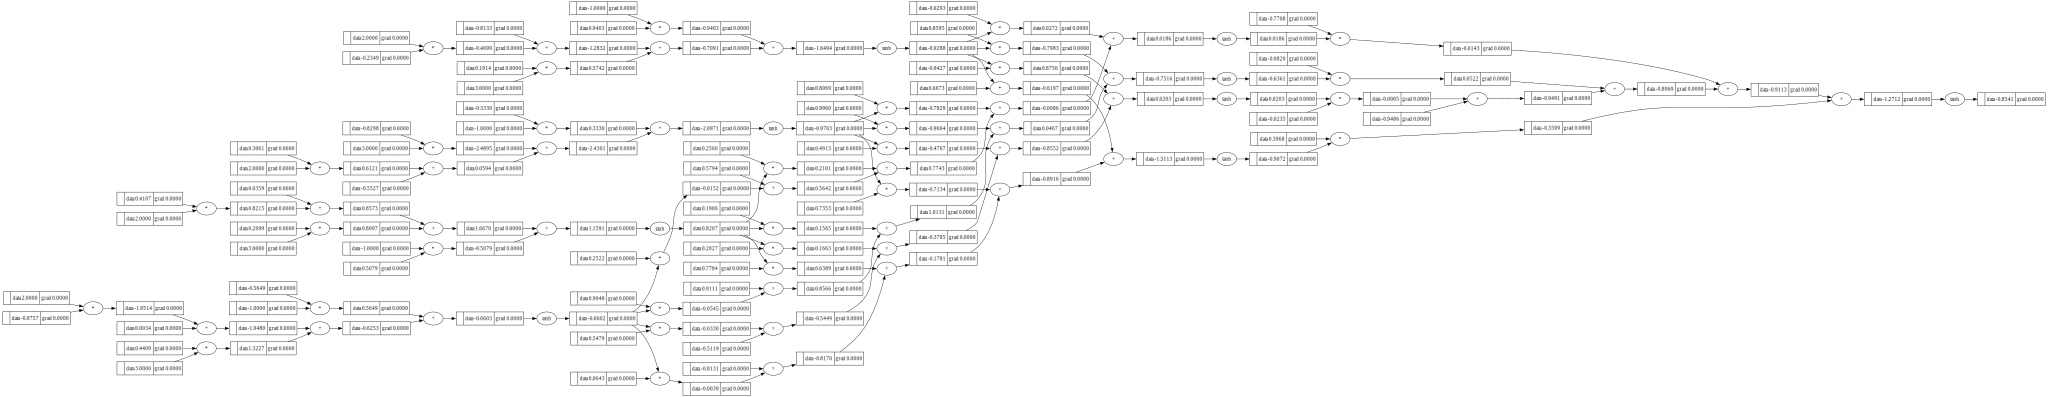

In [530]:
draw_dot(n(x))

In [531]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [532]:
for k in range (20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)


0 7.046126735677925
1 6.137889990476674
2 3.7039013345483855
3 1.9194167614756728
4 1.3701945714783506
5 0.8811421683108477
6 0.561608878031338
7 0.3828242346044936
8 0.28009988583784506
9 0.21654309940611155
10 0.17438816576106417
11 0.14481023471383817
12 0.1231128134770369
13 0.10662248630497569
14 0.09372598215678196
15 0.08340064659604556
16 0.07497080612207471
17 0.06797412182772462
18 0.062084635398905935
19 0.057066553593519274


In [533]:
ypred

[Value(data=0.8645868678904114),
 Value(data=-0.9361606217318457),
 Value(data=-0.8622468752384989),
 Value(data=0.8747863919273621)]